# Assignment 4
Jan Widanka

This assignment requires the implementation of the original $\textit{Nagel-Schreckenberg}$ model of freeway traffic. It is a simple model that helps simulate and understand the behavior of traffic flow on a single-lane road. The model is often used in the study of traffic phenomena and has applications in transportation research.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings

## Traffic initialization

We will start our task with traffic initialization. The function $\textit{initialize_traffic}$ is used to initialize a traffic scenario on a one-dimensional road with a specified number of cells ($\textit{num_cells}$), maximum velocity ($\textit{max_velocity}$), and density of the cars ($\textit{density}$). The density is a fraction representing the proportion of cells on the road that should be occupied by cars. $\textit{random_positions}$ randomly selects $\textit{num_cars}$ unique positions on the road without replacement. These positions will be the initial positions of the cars. The cars are placed on the road with random velocities based on the given parameters. The function returns the initialized road as an array, where each element represents the velocity of a vehicle at the corresponding position on the road.

In [2]:
def initialize_traffic(num_cells, max_velocity, density):
    road = -np.ones(num_cells, dtype=int) 
    num_cars = int(density * num_cells)
    random_positions = np.random.choice(num_cells, size=num_cars, replace=False)
    velocities_of_cars = np.random.randint(0, max_velocity + 1, size=num_cars)
    road[random_positions] = velocities_of_cars
    return np.array(road)

## $\textit{Nagel-Schreckenberg}$ model rules

Now we will focus on the model rules. Here the function $\textit{nagel_schreckenberg}$ represents a step in the simulation of the implemented traffic model. The $\textit{car_pos}$ variable finds the positions of cars on the current road. It is used to iterate over the positions of the cars in the subsequent steps. After that we have four actions. First we iterate over the positions of cars and increase their velocity if it is less than the maximum velocity (acceleration). Then we iterate over the positions of cars and check the distance to the next car ahead. We reduce the velocity of a car if it is greater than the distance to the next car. Next action is randomization, where we generate a random binary array with probabilities defined by p, so that we can probabilistically slow down cars. Finally we perform car motion, that iterates over the positions of cars and calculates their new position based on their velocity. It also updates the $\textit{new_road}$ array with the new positions of the cars. The updated road configuration is returned for further simulation.

In [3]:
def nagel_schreckenberg(road, max_velocity, p):
    new_road = -np.ones(len(road), dtype = int)
    car_pos = np.argwhere(road != -1)
    
    # Acceleration
    for i in car_pos:
            if road[i] < max_velocity:
                road[i] += 1
    # Slowing down
    for i in car_pos:
        if road[i] > 0:
            distance_to_next_car = 1
            while road[(i + distance_to_next_car) % len(road)] == -1:
                distance_to_next_car += 1
            road[i] = min(road[i], distance_to_next_car - 1)

    # Randomization
    random_slowdown = np.random.binomial(1, p, size=len(road))
    road = np.where((road > 0) & random_slowdown, road - 1, road)

    # Car motion
    for i in car_pos:
        new_position = (i + road[i]) % len(road)
        new_road[new_position] = road[i]

    return new_road

## Simulation

After implementing the $\textit{Nagel-Schreckenberg}$ model we are ready to perform a simulation. Here we will use the function $\textit{simulate}$, which takes number of cells, density of the cars, maximum velocity, probability of slowing down ($p$) and number of steps ($\textit{num_steps}$) as an arguments. First we initialize a $\textit{states_list}$ with the initial state of the road generated by the $\textit{initialize_traffic}$ function. Then we iterate over the specified number of steps and inside we use $\textit{current_state}$, which eates a copy of the current state to avoid modifying the original state during the simulation step. After that we call our previous $\textit{nagel_schreckenberg}$ function to simulate one step of the Nagel–Schreckenberg model on the current state. And finally we append the state to the previous list of states and return an array of the $\textit{states_list}$, which contains every the states of the road at each simulation step.

In [4]:
def simulate(num_cells, density, max_velocity, p, num_steps):
    states_list = [initialize_traffic(num_cells, max_velocity, density)]
    
    for _ in range(num_steps):
        current_state = states_list[-1].copy()
        current_state = nagel_schreckenberg(current_state, max_velocity, p)
        states_list.append(current_state)
        
    return np.array(states_list)

## Results

### Evolution of the system for different values of $p$

To visualize the evolution of the system we need to switch the values different than $-1$ to $0$ and all values equal $-1$ to $1$. To have all plots in one place we create function $\textit{plotting}$, which contains the change of the values that I mentioned. 

In [11]:
def plotting(simulation_result, p_value, subplot_num):
    ax = plt.subplot(2, 2, subplot_num)
    simulation_result[simulation_result != -1] = 0
    simulation_result[simulation_result == -1] = 1
    ax.imshow(simulation_result, cmap='Greys_r')
    ax.set_title(f'Evolution of the system for $p={p_value}$', fontsize = 14)

Now we can define our parameters and after that plot the evolution of the system for different values of probability of slowing down. Here I took the density of the cars equal $0.35$.

In [12]:
num_cells = 100
density = 0.35
max_velocity = 5
p_values = [0.1, 0.2, 0.3, 0.6]
num_steps = 100

simulation_results = [simulate(num_cells, density, max_velocity, p, num_steps) for p in p_values]

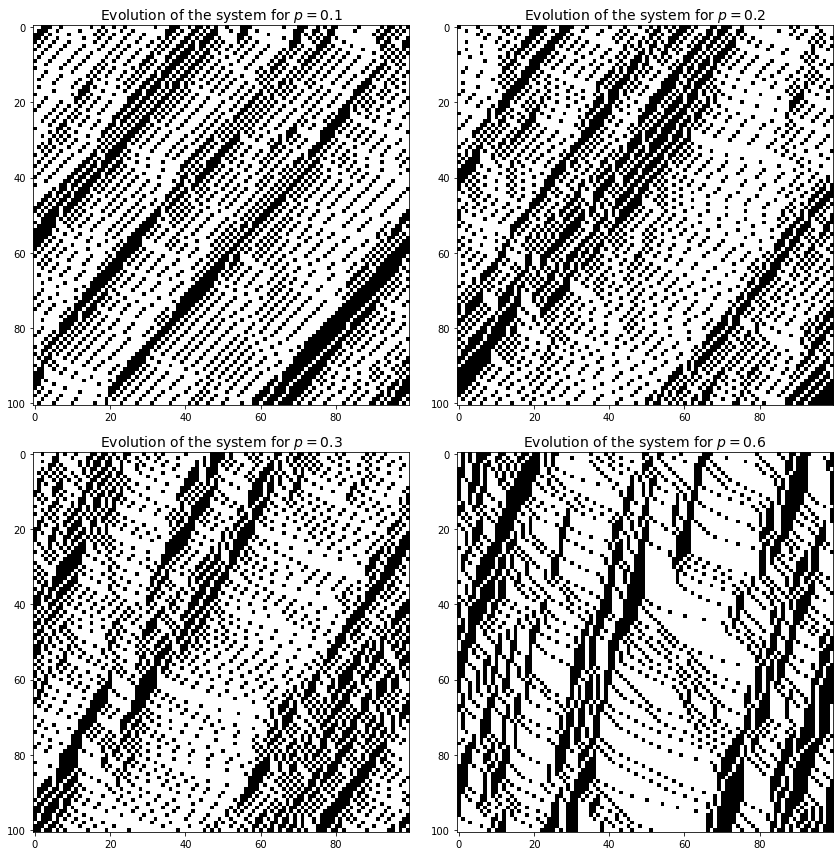

In [13]:
plt.figure(figsize=(12, 12))

for i, result in enumerate(simulation_results):
    plotting(result, p_values[i], i + 1)

plt.tight_layout()
plt.show()

Each line of pixels on the plot represents the road, which contains $100$ cells. Here black pixels represent cells with the cars in them and white ones are the empty cells. Each subplot represents the evolution of the traffic system over a specified number of simulation step for a particular probability of slowing down. Higher values of $p$ lead to more frequent random slowdowns, which can result in increased fluctuations and less predictable traffic flow. We can observe some specific patterns of intermittent congestion, traffic waves, or smooth flow in the evolution of the system. These patterns are influenced by the combination of the initial conditions, randomization, and the dynamic behavior of cars.

### Average velocity

Now we move on to the second task. Here we are going to plot average velocity depending on density of the cars. The function $\textit{get_average_velocity}$ takes number of cells, density of the cars, maximum velocity, probability of slowing down, number of steps and repetitions ($\textit{reps}$). First we create an empty list $\textit{average_velocities}$ to store the average velocities from each simulation repetition. Then we iterate over specified number of repetitions for simulating the $\textit{Nagel-Schreckenberg}$ model. We call our previous $\textit{simulate}$ function. Then we find the positions of the cars using $\textit{car_positions}$, so everything which is not an empty space ($-1$). After that we iterate over the positions of cars and extract their velocities. These velocities are then appended to the $\textit{average_velocities}$ list. Finally we calculate and return the mean of all the recorded average velocities.

In [8]:
def get_average_velocity(num_cells, density, max_velocity, p, num_steps, reps):
    average_velocities = []

    for _ in range(reps):
        nagel_sim_result = simulate(num_cells, density, max_velocity, p, num_steps)

        car_positions = np.argwhere(nagel_sim_result != -1)
        for i in car_positions:
            velocities = nagel_sim_result[i[0], i[1]]
            average_velocities.append(velocities)

    return np.mean(average_velocities)

### Parameters

For this task we define our parameters in the following way:

In [9]:
num_cells = 100
dens_vals = np.arange(0, 1.01, 0.01)
max_velocity = 5
p_values = [0, 0.2, 0.35, 0.5, 0.75]
num_steps = 100
reps = 100

The final plot of the average velocities would be presented after 100 repetitions.

## Plotting the final result

Finally we can plot the final result, so the average velocity depending on the density of the cars. 

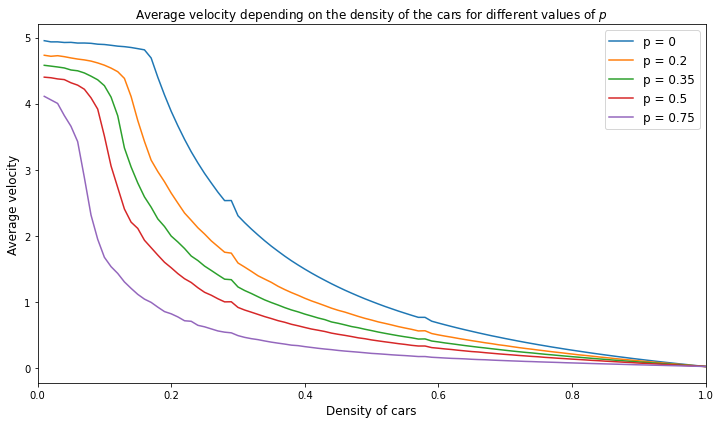

In [10]:
warnings.filterwarnings('ignore')

p_average_velocities = []
for p in p_values:
    average_velocities = [get_average_velocity(num_cells, density, max_velocity, p, num_steps, reps) for density in dens_vals]
    p_average_velocities.append(average_velocities)
    
plt.figure(figsize=(10, 6))
for i, values in enumerate(p_average_velocities):
    plt.plot(dens_vals, values, label=f'p = {p_values[i]}')

plt.xlabel('Density of cars', fontsize = 12)
plt.ylabel('Average velocity', fontsize = 12)
plt.title('Average velocity depending on the density of the cars for different values of $p$', fontsize = 12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.xlim(0, 1)
plt.show()

From the plot of the average velocity we can see that as the density of cars increases, the average velocity tends to decrease. This observation can correspond to real-world traffic behavior. At higher densities, cars experience more interactions and congestion, leading to lower average velocities. Higher values of $p$ introduce more randomness in the system, which can lead to increased fluctuations in the average velocity. 